In [561]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import yaml
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import block_diag

DATA_PATH = Path("..") / "datasets"

SARCOS_PATH = DATA_PATH / "sarcos" / "processed"
PARKINSONS_PATH = DATA_PATH / "parkinsons" / "processed"
NANO_PATH = DATA_PATH / "nanoparticle" / "processed"

In [69]:
# try sarcos

x_train = np.loadtxt(SARCOS_PATH / "x_train.csv", delimiter=",")
x_val = np.loadtxt(SARCOS_PATH / "x_val.csv", delimiter=",")
x_test = np.loadtxt(SARCOS_PATH / "x_test.csv", delimiter=",")

y_train = np.loadtxt(SARCOS_PATH / "y_train.csv", delimiter=",")
y_val = np.loadtxt(SARCOS_PATH / "y_val.csv", delimiter=",")
y_test = np.loadtxt(SARCOS_PATH / "y_test.csv", delimiter=",")

x_ss = StandardScaler()
x_train = x_ss.fit_transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

y_ss = StandardScaler()
y_train = y_ss.fit_transform(y_train)
y_val = y_ss.transform(y_val)
y_test = y_ss.transform(y_test)

print(x_train.shape, y_train.shape)

n_tasks = y_train.shape[1]

x_train = np.tile(x_train, (n_tasks, 1, 1))
x_val = np.tile(x_val, (n_tasks, 1, 1))
x_test = np.tile(x_test, (n_tasks, 1, 1))

y_train = np.transpose(y_train)
y_val = np.transpose(y_val)
y_test = np.transpose(y_test)

print(x_train.shape, y_train.shape)

(34262, 21) (34262, 7)
(7, 34262, 21) (7, 34262)


In [70]:
from mutar import DirtyModel

X = np.array(
    [
        [[3, 1, 0, 0, 0], [2, 0, 0, 0, 0], [1, 0, 0, 0, 0]],
        [[0, 2, 0, 0, 0], [-1, 3, 0, 0, 0], [1, -2, 0, 0, 0]],
    ],
    dtype=float,
)
coef = np.array([[1.0, 1.0], [0.0, -1], [0, 0], [0, 0], [0, 0]])

y = np.array([x.dot(c) for x, c in zip(X, coef.T)])
y += 0.1

print(f"X: (n_tasks, n_samples, n_features) {X.shape}")
print(X.shape, coef.T.shape, y.shape)

dirty = DirtyModel(alpha=0.15, beta=0.12).fit(X, y)
print(dirty.coef_shared_.shape)
print(dirty.coef_shared_)

print(dirty.coef_specific_.shape)
print(dirty.coef_specific_)

X: (n_tasks, n_samples, n_features) (2, 3, 5)
(2, 3, 5) (2, 5) (2, 3)
(5, 2)
[[ 0.4652447  0.3465437]
 [ 0.        -0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]]
(5, 2)
[[ 0.35453532  0.        ]
 [ 0.         -1.20766296]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [98]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


dummy_results = train_model(DummyRegressor, strategy="mean")
linear_results = train_model(LinearRegression)

pd.DataFrame(linear_results).round(3).T

100%|██████████| 7/7 [00:00<00:00, 29.00it/s]


,train,val,test
task 0,0.074,0.074,0.074
task 1,0.103,0.102,0.102
task 2,0.091,0.094,0.090
task 3,0.051,0.053,0.050
task 4,0.146,0.151,0.144
task 5,0.274,0.277,0.271
task 6,0.065,0.067,0.064


In [237]:
from mutar import DirtyModel

model = DirtyModel(
    alpha=1.0,  # shared penalty
    beta=1.0,  # task-specific penalty
)
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

y_train_err = np.mean((y_train_pred - y_train) ** 2, axis=1)
y_val_err = np.mean((y_val_pred - y_val) ** 2, axis=1)
y_test_err = np.mean((y_test_pred - y_test) ** 2, axis=1)

columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]
df = pd.DataFrame(
    np.vstack([y_train_err, y_val_err, y_test_err]).T,
    columns=columns,
    index=index,
)

df.round(3)

,train,val,test
task 0,0.963,0.993,0.944
task 1,0.663,0.666,0.648
task 2,0.625,0.635,0.618
task 3,0.587,0.599,0.574
task 4,0.857,0.885,0.862
task 5,0.995,0.989,0.968
task 6,0.578,0.580,0.570


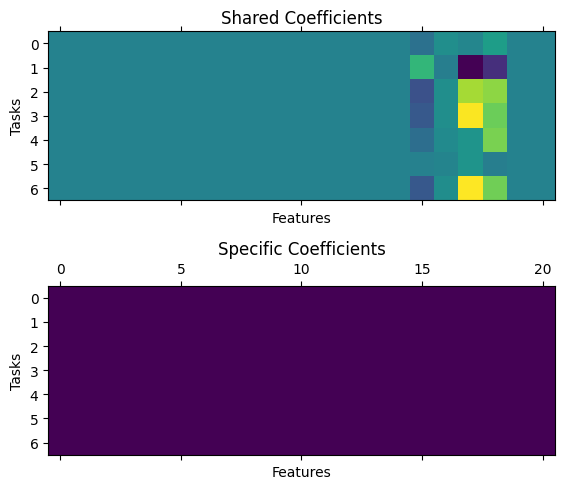

In [238]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(model.coef_shared_.T)
axs[0].set_title("Shared Coefficients")

axs[1].matshow(model.coef_specific_.T)
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()

In [248]:
from JOPLEn.multitask import MTJOPLEn
from JOPLEn.partitioner import VPartition

vpart_params = (
    {"n_partitions": 100, "n_cells": 2},
    {
        "max_iters": 1000,
        "lam_core": 5.0,
        "lam_task": 10,
        "core_alpha": 0.0,
        "task_alpha": 0.0,
        "print_epochs": 10,
        "mu": 0.1,
    },
)
# vpart_params = (
#     {"n_partitions": 100, "n_cells": 2},
#     {
#         "max_iters": 1000,
#         "lam_core": 1.0,
#         "lam_task": 0.7,
#         "core_alpha": 0.0,
#         "task_alpha": 0.0,
#         "print_epochs": 10,
#         "mu": 0.1,
#     },
# )

model = MTJOPLEn(
    VPartition,
    **vpart_params[0],
    random_state=0,
)
history = model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    **vpart_params[1],
)

[16:06:42]: Epoch     10 | TrL: 0.938009, 0.788927, 0.741040, 0.704970, 0.892093, 0.964636, 0.712027 | VaL: 0.951506, 0.790085, 0.746594, 0.712481, 0.907130, 0.961036, 0.714261 | CNorm: 12.121696 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:    7 | WsNz:    0,    0,    0,    0,    0,    0,    0
[16:06:42]: Epoch     20 | TrL: 0.949173, 0.792548, 0.753652, 0.713257, 0.905670, 0.974857, 0.718338 | VaL: 0.963244, 0.793955, 0.759420, 0.720993, 0.920774, 0.971357, 0.720538 | CNorm: 11.242280 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:    5 | WsNz:    0,    0,    0,    0,    0,    0,    0
[16:06:43]: Epoch     30 | TrL: 0.956681, 0.797647, 0.763240, 0.723181, 0.908670, 0.976435, 0.726372 | VaL: 0.971154, 0.799210, 0.769094, 0.731062, 0.923745, 0.972971, 0.728561 | CNorm: 10.723478 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:    5 | WsNz:    0,    0,    0,    0,    0,    0,    0
[16:06:43]: Epoch     40 | TrL: 0.961472, 0.800424, 0.7682

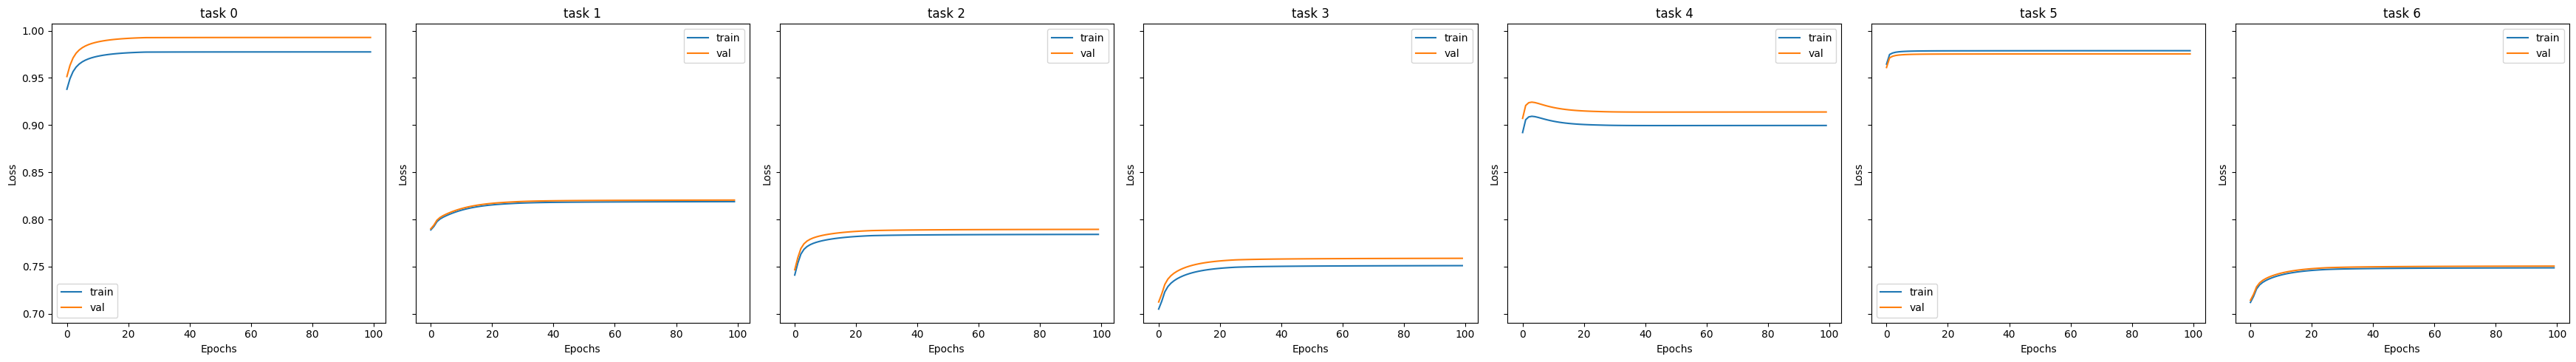

,train,val,test
task 0,0.956,0.986,0.936
task 1,0.670,0.673,0.657
task 2,0.615,0.623,0.608
task 3,0.564,0.576,0.551
task 4,0.809,0.835,0.814
task 5,0.958,0.952,0.931
task 6,0.561,0.563,0.555


In [249]:
fig, axs = plt.subplots(1, n_tasks, figsize=(5 * n_tasks, 5), sharey=True, sharex=True)

train_loss = np.array(history["train_loss"])
val_loss = np.array(history["val_loss"])

for i, ax in enumerate(axs):
    ax.plot(train_loss[:, i], label="train")
    ax.plot(val_loss[:, i], label="val")
    ax.set_title(f"task {i}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

plt.tight_layout()
plt.show()

y_train_pred = [model.predict(x_train[i], i).flatten() for i in range(n_tasks)]
y_val_pred = [model.predict(x_val[i], i).flatten() for i in range(n_tasks)]
y_test_pred = [model.predict(x_test[i], i).flatten() for i in range(n_tasks)]

y_train_err = np.mean((y_train_pred - y_train) ** 2, axis=1)
y_val_err = np.mean((y_val_pred - y_val) ** 2, axis=1)
y_test_err = np.mean((y_test_pred - y_test) ** 2, axis=1)

columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]
df = pd.DataFrame(
    np.vstack([y_train_err, y_val_err, y_test_err]).T,
    columns=columns,
    index=index,
)
df.round(3)

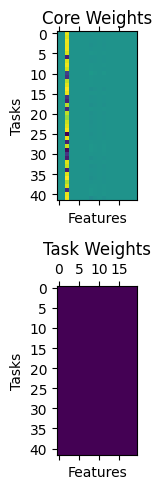

In [38]:
def max_signed_weights(weights):
    indices_max_abs = np.argmax(np.abs(weights), axis=-1)
    weights = np.take_along_axis(
        weights, indices_max_abs[..., np.newaxis], axis=-1
    ).squeeze(-1)
    return weights


core_weights = max_signed_weights(model.cwb.get())
task_weights = max_signed_weights(model.cws.get())

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)
axs[0].matshow(core_weights)
axs[0].set_title("Core Weights")
axs[1].matshow(task_weights)
axs[1].set_title("Task Weights")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

---

In [262]:
# try parkinsons

train = {}
val = {}
test = {}

for dir in sorted(PARKINSONS_PATH.iterdir(), key=lambda x: int(x.name)):
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[int(dir.name)] = {"x": x_train, "y": y_train}
    val[int(dir.name)] = {"x": x_val, "y": y_val}
    test[int(dir.name)] = {"x": x_test, "y": y_test}

In [263]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [448]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition

model = MTJOPLEn(
    # GBPartition,
    # n_partitions=100,
    VPartition,
    n_partitions=100,
    n_cells=2,
    random_state=0,
)

history = model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=100,
    lam_core=5.0,
    lam_task=10,
    core_alpha=0.01,
    task_alpha=0.01,
    print_epochs=2,
    mu=0.05,
)

[19:17:23]: Epoch      2 | TrL: 0.982229, 0.987660, 0.981287, 0.972775, 0.984177, 0.980650, 0.986838, 0.997403, 0.991766, 0.989556, 0.982017, 0.989298, 0.984015, 0.989985, 0.927118, 0.972194, 0.990453, 0.978168, 0.986627, 0.994561, 0.984158, 0.989332, 0.962361, 0.989963, 0.978315, 0.981128, 0.973017, 0.991325, 0.985129, 0.988437, 0.988397, 0.978854, 0.981255, 0.988438, 0.991988, 0.993286, 0.932594, 0.996945, 0.993376, 0.992903, 0.990106, 0.963110 | VaL: 1.016756, 0.937125, 0.896314, 1.082976, 0.898275, 1.012415, 1.004208, 1.026289, 1.216776, 0.921827, 1.050522, 1.035041, 0.949545, 1.050943, 1.100406, 1.133020, 0.994415, 0.887716, 0.943724, 1.093006, 0.994107, 0.996595, 0.869784, 1.163501, 1.076051, 0.971236, 1.023663, 1.384726, 0.879138, 0.941597, 1.013551, 1.003798, 0.929718, 1.094979, 1.050313, 0.997329, 1.030944, 0.900497, 1.046968, 1.298331, 1.022778, 1.037451 | CNorm: 7.271019 | TNorm: 0.000000 | CFNorm: 0.000000 | TFNorm: 0.000000 | WbNz:   17 | WsNz:    0,    0,    0,    0,    0

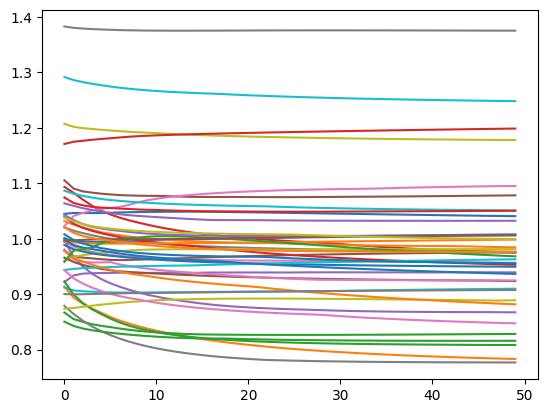

In [441]:
plt.plot(history["val_loss"], label="train")
plt.show()

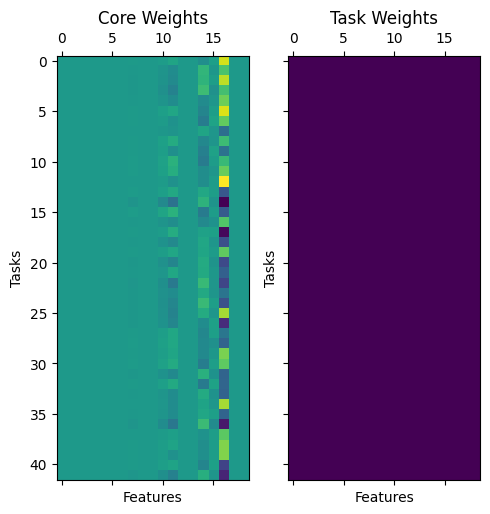

In [449]:
core_weights = max_signed_weights(model.cwb.get())
task_weights = max_signed_weights(model.cws.get())

fig, axs = plt.subplots(1, 2, figsize=(5, 10), sharey=True, sharex=True)
axs[0].matshow(core_weights)
axs[0].set_title("Core Weights")
axs[1].matshow(task_weights)
axs[1].set_title("Task Weights")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [450]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)

    np.random.seed(random_state)
    y_values = np.arange(len(arr))[:, None] + np.random.uniform(
        -jitter, jitter, size=arr.shape
    )

    for xs, ys in zip(arr, y_values):
        ax.scatter(xs, ys, **scatter_kwargs)

    # for x_idx, x_values in enumerate(arr):
    #     # Apply jitter to x-axis positions
    #     y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
    #     ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    ax.set_xlim(x_lim)
    ax.set_ylim(-0.5, len(arr) - 0.5)

    return ax, y_values

In [451]:
y_train_pred = [model.predict(x_train[i], i).flatten() for i in range(n_tasks)]
y_val_pred = [model.predict(x_val[i], i).flatten() for i in range(n_tasks)]
y_test_pred = [model.predict(x_test[i], i).flatten() for i in range(n_tasks)]

y_train_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_train, y_train_pred)]
y_val_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_val, y_val_pred)]
y_test_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_test, y_test_pred)]

In [452]:
def concat_datasets(
    X_datasets: list[np.ndarray], y_datasets: list[np.ndarray]
) -> tuple[np.ndarray]:
    padded_y = []
    padded_X = []
    mask = []

    num_datasets = len(y_datasets)
    max_samples = max([y.shape[0] for y in y_datasets])
    basis = np.eye(num_datasets, dtype=bool)

    for i, (y, X, b) in enumerate(zip(y_datasets, X_datasets, basis)):
        y = np.expand_dims(y, 0)
        X = np.expand_dims(X, 0)
        b = np.expand_dims(b, 1)

        task_padding = (i, num_datasets - i - 1)

        tmp_y = np.pad(y, [task_padding, (0, 0)], mode="constant")
        tmp_X = np.tile(X, (num_datasets, 1, 1))
        tmp_b = np.tile(b, (1, y.shape[1]))

        padded_y.append(tmp_y)
        padded_X.append(tmp_X)
        mask.append(tmp_b)

    y_out = np.concatenate(padded_y, axis=-1)
    x_out = np.concatenate(padded_X, axis=1)
    mask_out = np.concatenate(mask, axis=-1)

    return x_out, y_out, mask_out


def get_out_data(y_pred, mask_out):
    indices = [0] + list(np.cumsum(mask_out.sum(axis=1)))[:-1] + [None]
    tmp = y_pred[mask_out]
    return [tmp[i1:i2] for i1, i2 in zip(indices[:-1], indices[1:])]

In [453]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

model = DirtyModel(
    alpha=0.02,  # shared penalty
    beta=0.01,  # task-specific penalty
)
model.fit(x_train_out, y_train_out, train_mask_out)

y_train_pred = get_out_data(model.predict(x_train_out), train_mask_out)
y_val_pred = get_out_data(model.predict(x_val_out), val_mask_out)
y_test_pred = get_out_data(model.predict(x_test_out), test_mask_out)

dl_train_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_train, y_train_pred)]
dl_val_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_val, y_val_pred)]
dl_test_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_test, y_test_pred)]

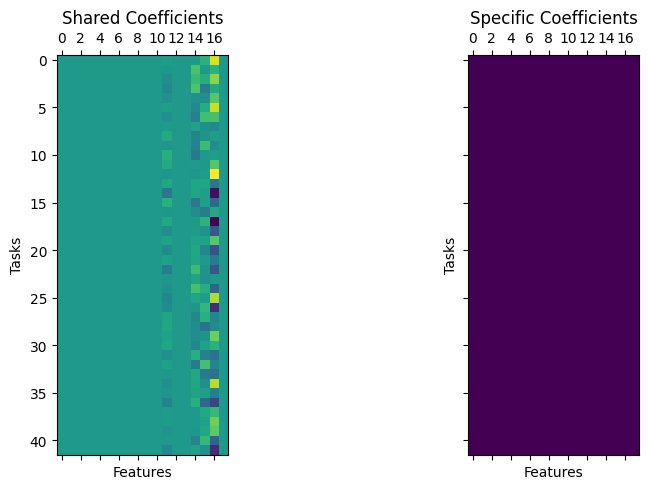

In [454]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(model.coef_shared_.T)
axs[0].set_title("Shared Coefficients")

axs[1].matshow(model.coef_specific_.T)
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [455]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


linear_results = train_model(LinearRegression)
naive_results = train_model(DummyRegressor, strategy="mean")
linear_test_err = [linear_results[f"task {i}"]["test"] for i in range(n_tasks)]
naive_test_err = [naive_results[f"task {i}"]["test"] for i in range(n_tasks)]

100%|██████████| 42/42 [00:00<00:00, 7695.30it/s]


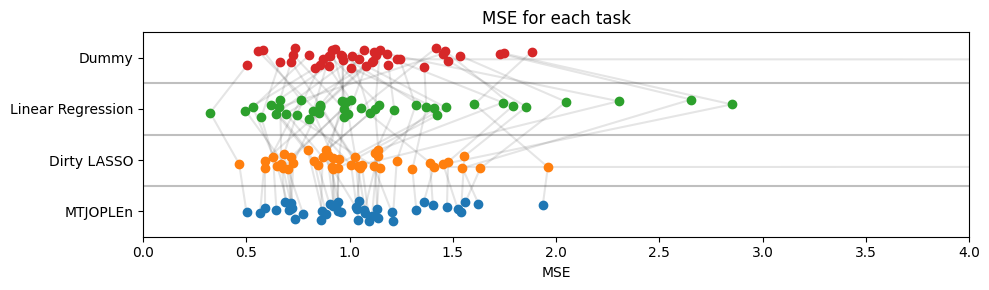

In [456]:
columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]

data = np.vstack([y_test_err, dl_test_err, linear_test_err, naive_test_err])

fig, ax = plt.subplots(figsize=(10, 3))

ax, y_values = plot_strip(
    data,
    scatter_kwargs={"marker": "o"},
    ax=ax,
)

ax.plot(data.reshape(4, -1), y_values, color="k", alpha=0.1, zorder=0)

ax.set_xlabel("MSE")
ax.set_yticks(range(4), ["MTJOPLEn", "Dirty LASSO", "Linear Regression", "Dummy"])
ax.set_title("MSE for each task")

ax.set_xlim(0, 4)
plt.tight_layout()
plt.show()

In [541]:
np.random.seed(0)

x = np.random.normal(size=(1000, 2))

# y1 = x[:, 0] ** 2 + x[:, 1]
# y2 = -x[:, 0] ** 2 + x[:, 1]

# y1 = np.sin(2 * x[:, 0]) + x[:, 1] / 3
# y2 = x[:, 0] / 3 + np.cos(2 * x[:, 1])

y1 = np.sin(x[:, 0] + x[:, 1])
y2 = np.cos(x[:, 0] - x[:, 1])

y = np.stack([y1, y2], axis=0)

In [542]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y1, mode="markers", marker=dict(color="red"))
)

# Add the second scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y2, mode="markers", marker=dict(color="blue"))
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

[0.50820364 0.37837968]


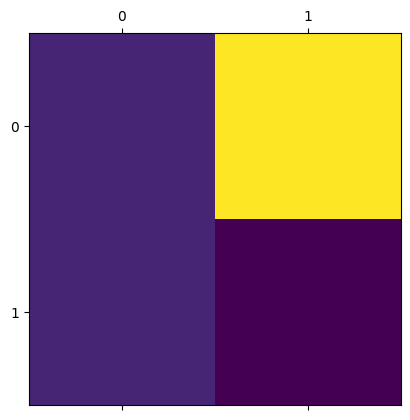

In [545]:
model = DirtyModel(alpha=0.4, beta=10)
model.fit(np.tile(np.expand_dims(x, 0), (2, 1, 1)), y)

y_pred = model.predict(np.tile(np.expand_dims(x, 0), (2, 1, 1)))
print(np.mean((y_pred - y) ** 2, axis=1))

plt.matshow(model.coef_shared_.T)
plt.show()

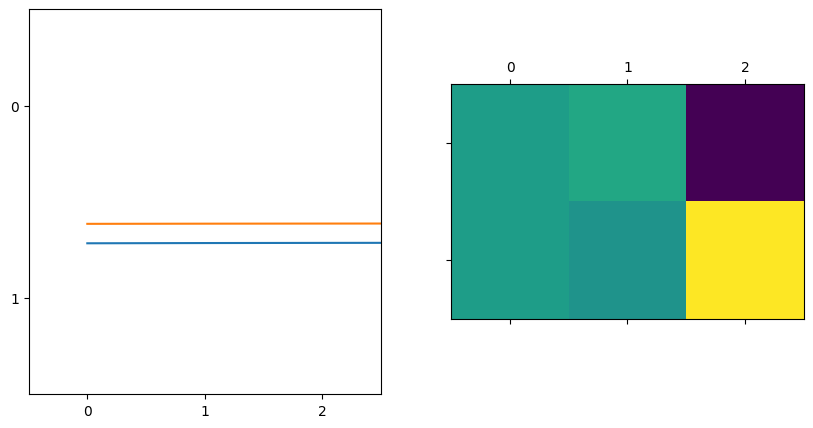

[0.51191828 0.37782288]


In [559]:
model = MTJOPLEn(
    VPartition,
    n_partitions=100,
    n_cells=10,
    random_state=0,
)

history = model.fit(
    np.tile(np.expand_dims(x, 0), (2, 1, 1)),
    y,
    max_iters=100,
    lam_core=2.05,
    lam_task=10,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=1,
    mu=0.01,
    verbose=0,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].plot(history["train_loss"])
core_weights = max_signed_weights(model.cwb.get())
axs[1].matshow(core_weights)
plt.show()

y_pred = [model.predict(x, i).flatten() for i in range(2)]
print(np.mean([(yt - yp) ** 2 for yt, yp in zip(y, y_pred)], axis=1))

---

In [566]:
train = {}
val = {}
test = {}

dirs = sorted(NANO_PATH.iterdir())
dir_names = [dir.name for dir in dirs]

for dir in dirs:
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[dir.name] = {"x": x_train, "y": y_train}
    val[dir.name] = {"x": x_val, "y": y_val}
    test[dir.name] = {"x": x_test, "y": y_test}

In [567]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [688]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition
from JOPLEn.enums import NormType

model = MTJOPLEn(
    # GBPartition,
    # n_partitions=100,
    VPartition,
    n_partitions=1000,
    n_cells=2,
    random_state=0,
)

history = model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=2000,
    lam_core=755,
    lam_task=1000,
    core_alpha=0.1,
    task_alpha=0.1,
    print_epochs=100,
    mu=0.001,
    norm_type=NormType.LINF1,
)

y_train_pred = [model.predict(x_train[i], i).flatten() for i in range(n_tasks)]
y_val_pred = [model.predict(x_val[i], i).flatten() for i in range(n_tasks)]
y_test_pred = [model.predict(x_test[i], i).flatten() for i in range(n_tasks)]

y_train_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_train, y_train_pred)]
y_val_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_val, y_val_pred)]
y_test_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_test, y_test_pred)]

print("Train:", list(np.around(y_train_err, 2)))
print("Val:  ", list(np.around(y_val_err, 2)))
print("Test: ", list(np.around(y_test_err, 2)))

[23:01:24]: Epoch    100 | TrL: 1.174089, 1.110371 | VaL: 1.079846, 1.134284 | CNorm: 0.877559 | TNorm: 3.161617 | CFNorm: 0.003093 | TFNorm: 0.003093 | WbNz:   35 | WsNz:    0,    0
[23:01:28]: Epoch    200 | TrL: 0.935009, 0.925078 | VaL: 0.957230, 0.903274 | CNorm: 1.102045 | TNorm: 2.913140 | CFNorm: 0.002850 | TFNorm: 0.002850 | WbNz:   36 | WsNz:    0,    0
[23:01:31]: Epoch    300 | TrL: 0.997319, 0.956701 | VaL: 0.945422, 0.939498 | CNorm: 1.045047 | TNorm: 1.651763 | CFNorm: 0.001466 | TFNorm: 0.001466 | WbNz:   33 | WsNz:    0,    0
[23:01:35]: Epoch    400 | TrL: 1.169605, 1.108706 | VaL: 1.081468, 1.135653 | CNorm: 0.915995 | TNorm: 3.163990 | CFNorm: 0.003097 | TFNorm: 0.003097 | WbNz:   31 | WsNz:    0,    0
[23:01:39]: Epoch    500 | TrL: 0.931271, 0.925341 | VaL: 0.956091, 0.906047 | CNorm: 1.126172 | TNorm: 2.918073 | CFNorm: 0.002855 | TFNorm: 0.002855 | WbNz:   31 | WsNz:    0,    0
[23:01:43]: Epoch    600 | TrL: 0.997736, 0.956189 | VaL: 0.946898, 0.940603 | CNorm:

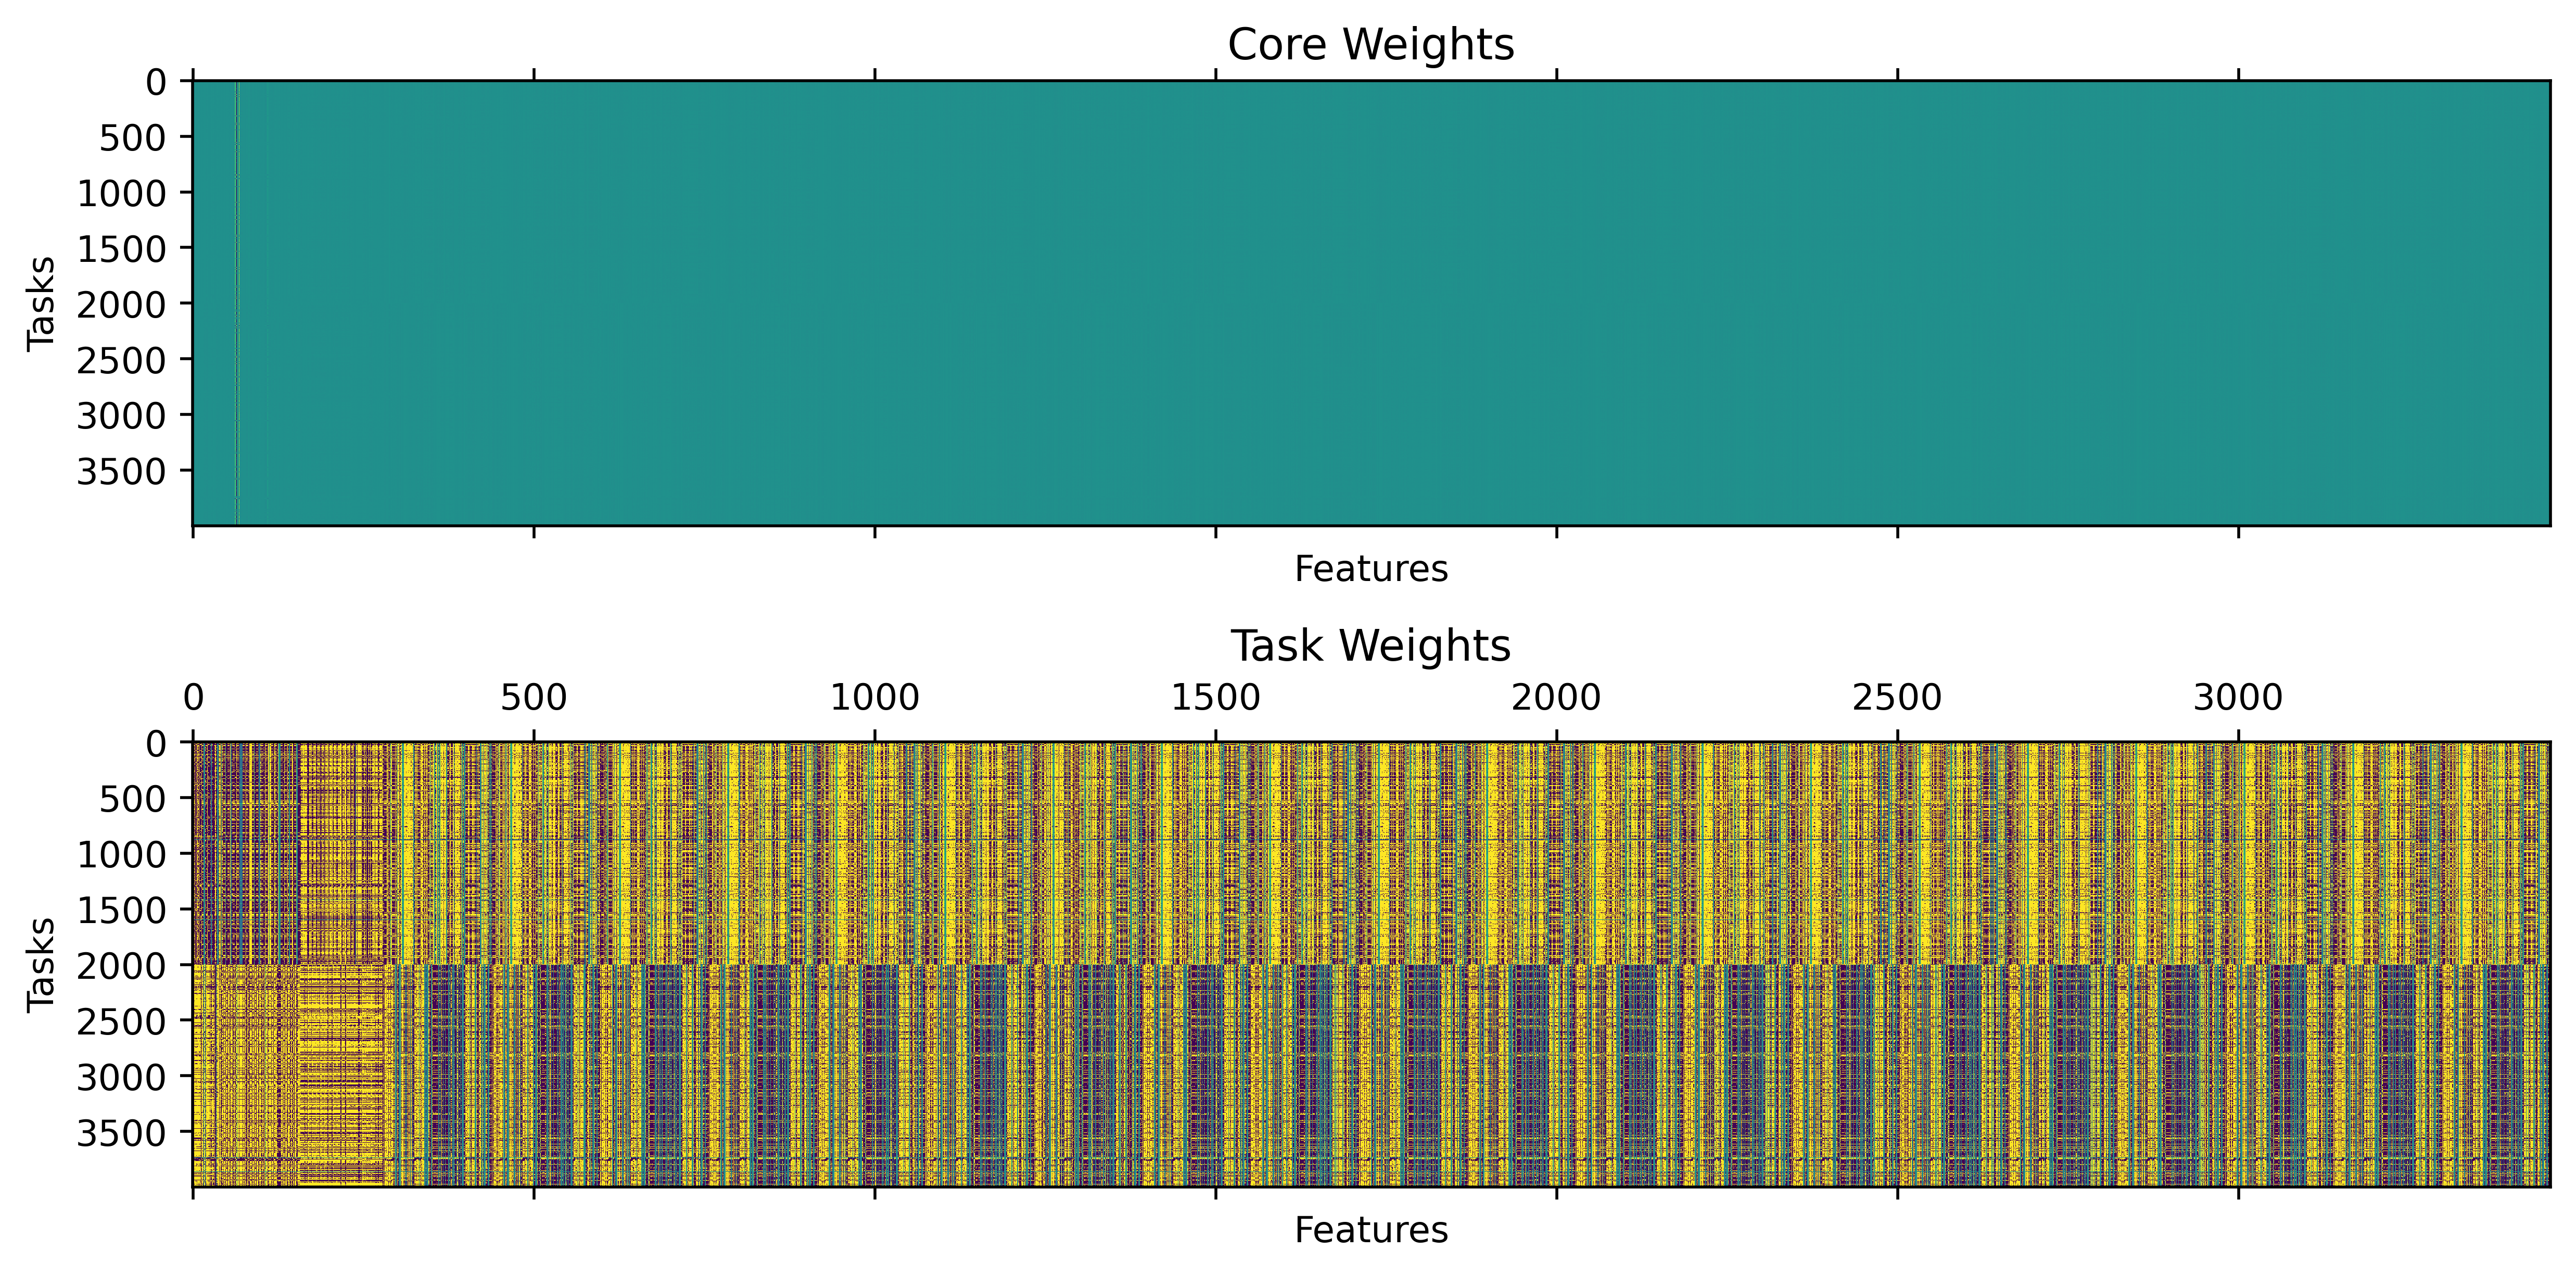

In [689]:
# core_weights = max_signed_weights(model.cwb.get())
# task_weights = max_signed_weights(model.cws.get())

core_weights = np.transpose(model.cwb.get(), (0, 2, 1)).reshape(
    -1, x_train[0].shape[1] + 1
)
task_weights = np.transpose(model.cws.get(), (0, 2, 1)).reshape(
    -1, x_train[0].shape[1] + 1
)

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True, dpi=500)
axs[0].matshow(core_weights, aspect="auto")
axs[0].set_title("Core Weights")
axs[1].matshow(task_weights, aspect="auto")
axs[1].set_title("Task Weights")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [695]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

model = DirtyModel(
    alpha=0.280,  # shared penalty
    beta=1.0,  # task-specific penalty
)
model.fit(x_train_out, y_train_out, train_mask_out)

y_train_pred = get_out_data(model.predict(x_train_out), train_mask_out)
y_val_pred = get_out_data(model.predict(x_val_out), val_mask_out)
y_test_pred = get_out_data(model.predict(x_test_out), test_mask_out)

dl_train_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_train, y_train_pred)]
dl_val_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_val, y_val_pred)]
dl_test_err = [np.mean((yt - yp) ** 2) for yt, yp in zip(y_test, y_test_pred)]

print("Train:", list(np.around(dl_train_err, 2)))
print("Val:  ", list(np.around(dl_val_err, 2)))
print("Test: ", list(np.around(dl_test_err, 2)))

print("# core features:", np.sum(np.sum(np.abs(model.coef_shared_), axis=1) > 1e-4))

Train: [0.95, 0.96]
Val:   [0.99, 0.96]
Test:  [0.82, 1.77]
# core features: 6


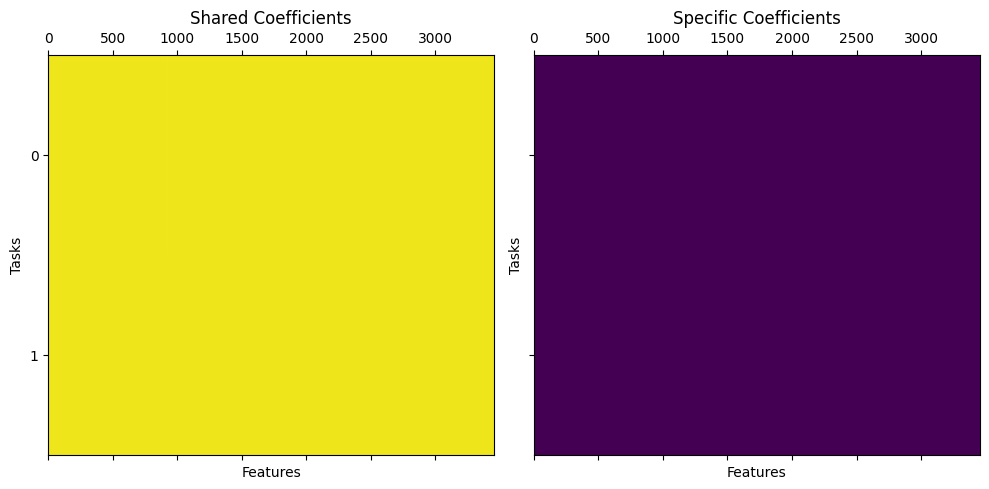

In [696]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(model.coef_shared_.T, aspect="auto")
axs[0].set_title("Shared Coefficients")

axs[1].matshow(model.coef_specific_.T, aspect="auto")
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [697]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


linear_results = train_model(LinearRegression)
naive_results = train_model(DummyRegressor, strategy="mean")
linear_test_err = [linear_results[f"task {i}"]["test"] for i in range(n_tasks)]
naive_test_err = [naive_results[f"task {i}"]["test"] for i in range(n_tasks)]

100%|██████████| 2/2 [00:00<00:00, 1662.76it/s]


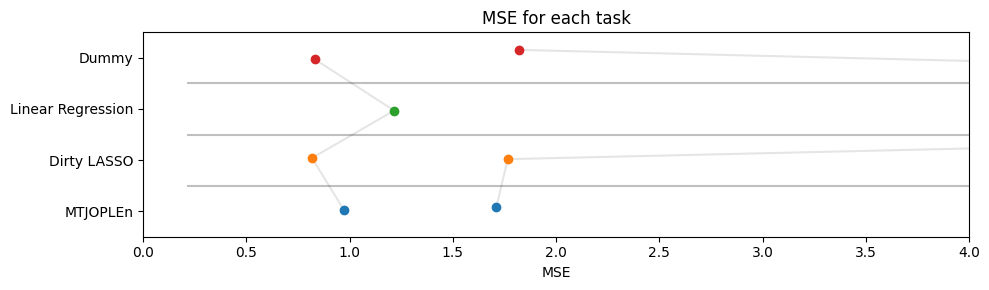

In [698]:
columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]

data = np.vstack([y_test_err, dl_test_err, linear_test_err, naive_test_err])

fig, ax = plt.subplots(figsize=(10, 3))

ax, y_values = plot_strip(
    data,
    scatter_kwargs={"marker": "o"},
    ax=ax,
)

ax.plot(data.reshape(4, -1), y_values, color="k", alpha=0.1, zorder=0)

ax.set_xlabel("MSE")
ax.set_yticks(range(4), ["MTJOPLEn", "Dirty LASSO", "Linear Regression", "Dummy"])
ax.set_title("MSE for each task")

ax.set_xlim(0, 4)
plt.tight_layout()
plt.show()